In [1]:
import numpy as np
# from sklearn.datasets import load_digits
from scipy.spatial.distance import pdist
# from sklearn.manifold import t_sne
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import os
import kaldi_io
import torch
from tqdm import tqdm
from scipy.stats import norm

plt.rc('font', family='Times New Roman', weight='semibold')

# import seaborn as sns
# sns.set(rc={'figure.figsize':(11.7,8.27)})
# palette = sns.color_palette("bright", 10)

In [31]:
from scipy.stats import norm
import statistics

In [2]:
data_dir = '/home/work2020/yangwenhao/project/SpeakerVerification-pytorch'

tdnn_xvector_dir = 'Data/xvector/TDNN_v5/cnceleb/klfb_egs_baseline/arcsoft/Mean_STAP_em512_wd5e4_var/cnceleb_dev_epoch50_fix'
tdnn_xvector_dict = {}
with open(os.path.join(data_dir, tdnn_xvector_dir, 'xvectors.scp'), 'r') as f:
    for l in f.readlines():
        uid,upath = l.split()
        tdnn_xvector_dict[uid] = upath
    
spk2uid_dict = {}
for uid in tdnn_xvector_dict:
    sid,_,_,_ = uid.split('-')
    spk2uid_dict.setdefault(sid, []).append(uid)
        

In [3]:
tdnn_ckp_dir = 'Data/checkpoint/TDNN_v5/cnceleb/klfb_egs_baseline/arcsoft/Mean_STAP_em512_wd5e4_var/checkpoint_50.pth'
tdnn_model = torch.load(data_dir +"/"+tdnn_ckp_dir)

In [4]:
classifier_Center = tdnn_model['state_dict']['classifier.W'].cpu()
print(classifier_Center.shape)

classifier_Center[:,1].shape

torch.Size([512, 800])


torch.Size([512])

In [5]:
lstm_dir = '/home/work2020/yangwenhao/project/lstm_speaker_verification/data'

cnc_dir = 'cnceleb/dev/wav.scp'
spk_domain_dict = {}
domains = set([])

with open(os.path.join(lstm_dir, cnc_dir), 'r') as f:
    
    for l in f.readlines():
        uid,upath = l.split()
        
        sid, domain,_,_ = uid.split('-')
        domains.add(domain)
        if sid in spk_domain_dict:
            spk_domain_dict[sid].add(domain)
        else:
            spk_domain_dict[sid] = set([domain])


In [109]:
domains = list(domains)
domains.sort()
domain2idx = {uid:i**2 for i,uid in enumerate(domains)}

spks = list(spk_domain_dict.keys())
spks.sort()
spk2idx = {sid:i for i,sid in enumerate(spks)}

In [7]:
list(spk_domain_dict.keys())[:10]

['id00000',
 'id00001',
 'id00002',
 'id00003',
 'id00004',
 'id00005',
 'id00006',
 'id00007',
 'id00008',
 'id00009']

In [80]:
numofdomains = []
for sid in spks:
    numofdomains.append(len(spk_domain_dict[sid]))
#     if len(spk_domain_dict[sid]) >= numofdomains:
#         print(sid, end='", "')
# id00004

In [110]:
# spk_domain_dict['id00007']
all_sids = ["id00047", "id00061"]

ConversionError: Failed to convert value(s) to axis units: ['advertisement', 'drama', 'entertainment', 'interview', 'live_broadcast', 'movie', 'play', 'recitation', 'singing', 'speech', 'vlog']

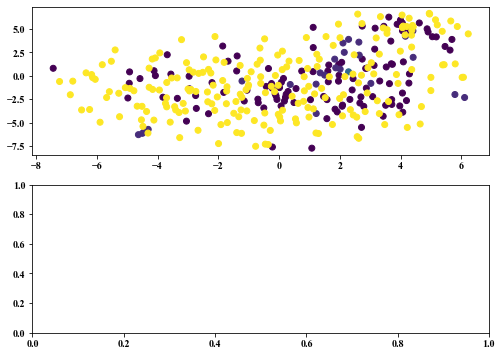

In [111]:
plt.figure(figsize=(18,6))

for i,this_sid in enumerate(all_sids):
    ax = plt.subplot(2,len(all_sids),i+1)
    j=0
    
    one_xvectors_dict = {}
    one_xvectors = []
    one_xvectors_dom = []
    one_xvectors_dom2cos = {}
    one_xvectors_domidx = []
    this_spk_center = classifier_Center[:, spk2idx[this_sid]]
    
    for uid in spk2uid_dict[this_sid]:
        
        this_vector = kaldi_io.read_vec_flt(data_dir + '/'+tdnn_xvector_dict[uid])
#             print(this_vector.shape)
        this_cos = torch.nn.functional.cosine_similarity(this_spk_center, torch.tensor(this_vector), dim=0) 

        one_xvectors_dict[uid] = this_vector
        one_xvectors.append(this_vector)
        dom = uid.split('-')[1]
        one_xvectors_dom.append(dom)
        one_xvectors_dom2cos.setdefault(dom,[]).append(float(this_cos))
        one_xvectors_domidx.append(domain2idx[dom])
    
#     print('1')
    one_xvectors = np.array(one_xvectors)
#     print(one_xvectors.shape)
    one_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(one_xvectors)
    ax.scatter(one_embedded[:,0], one_embedded[:,1], c=one_xvectors_domidx, label=one_xvectors_dom)
    
    ax = plt.subplot(2,len(all_sids),len(all_sids)+i+1)
    ax.set_xticks(domains)
    
    [ax.scatter([dom]*len(one_xvectors_dom2cos[dom]), one_xvectors_dom2cos[dom], alpha=0.1) for dom in one_xvectors_dom2cos]
    ax.tick_params(axis='x', labelrotation=30)
    ax.set_ylim(-0.2,1.0)
    
#     ax.scatter(one_xvectors_dom2cos)
    
#     ax.legend(one_xvectors_dom)
#     print(set(one_xvectors_dom))
#     plt.legend(list(set(one_xvectors_dom)))

In [20]:
miss_uid = []
all_cos = []
dom2cos = {}

for uid in tqdm(tdnn_xvector_dict, ncols=100):
    this_sid = uid.split('-')[0]
    this_spk_center = classifier_Center[:, spk2idx[this_sid]]

    this_vector = kaldi_io.read_vec_flt(data_dir + '/'+tdnn_xvector_dict[uid])
    this_cos = torch.nn.functional.cosine_similarity(this_spk_center, torch.tensor(this_vector), dim=0) 
    dom = uid.split('-')[1]
    dom2cos.setdefault(dom,[]).append(float(this_cos))
    
    all_cos.append(float(this_cos))


100%|███████████████████████████████████████████████████████| 91824/91824 [00:09<00:00, 9530.18it/s]


In [33]:
# plt.figure(figsize=(12,4))
# _ = plt.hist(all_cos, bins=100, density=True, cumulative=True,histtype='step')
# plt.xlim(0,1)

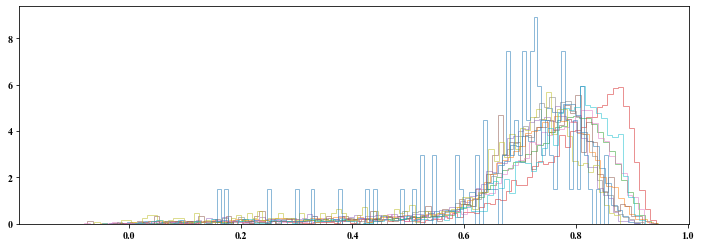

In [25]:
plt.figure(figsize=(12,4))
for i,dom in enumerate(dom2cos):
#     ax = plt.subplot(len(dom2cos),1,i+1)
    dom_cos = np.array(dom2cos[dom])
#     one_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(one_xvectors)
#     plt.scatter(dom_cos, [dom]*len(dom_cos), linewidths=0.1, alpha=0.2)
    plt.hist(dom_cos, alpha=0.5, bins=100, density=True, histtype='step')
    

<BarContainer object of 11 artists>

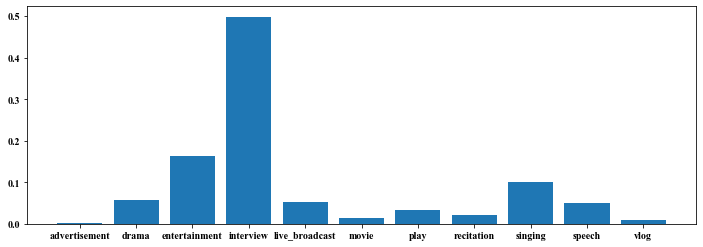

In [41]:
dom2num = []
plt.figure(figsize=(12,4))
for i,dom in enumerate(domains):
    dom2num.append(len(dom2cos[dom]))
    
plt.bar(domains, np.array(dom2num)/len(all_cos))

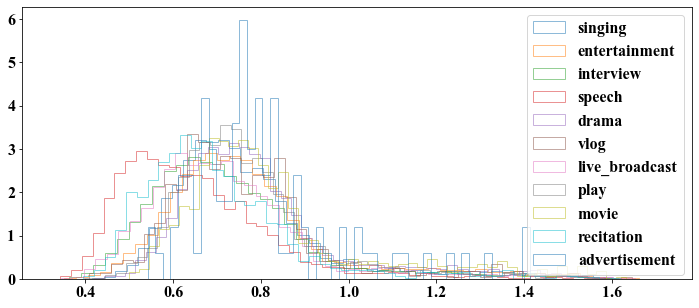

In [37]:
fontsize=16
plt.figure(figsize=(12,5))
for i,dom in enumerate(domains):
#     ax = plt.subplot(len(dom2cos),1,i+1)
    dom_cos = np.array(dom2cos[dom])
#     one_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(one_xvectors)
#     plt.scatter(dom_cos, [dom]*len(dom_cos), linewidths=0.1, alpha=0.2)
    _ = plt.hist(np.arccos(dom_cos), alpha=0.5, bins=50, density=True, histtype='step')

    plt.legend(list(dom2cos.keys()), fontsize=fontsize) 
_ = plt.yticks(fontsize=fontsize)
_ = plt.xticks(fontsize=fontsize)

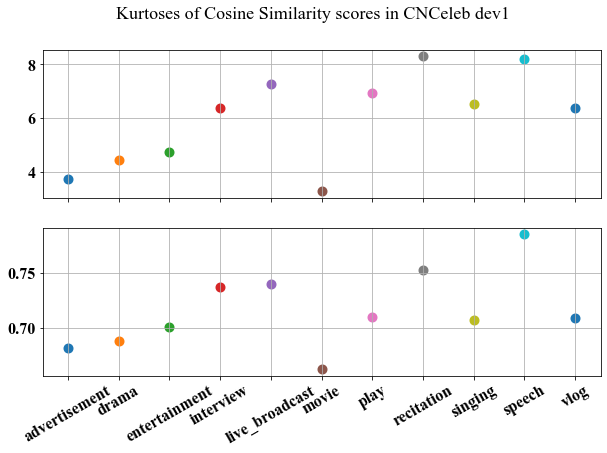

In [99]:
# x = np.arange(0, 2, 0.01)
plt.figure(figsize=(10,6))
plt.suptitle("Kurtoses of Cosine Similarity scores in CNCeleb dev1", fontsize=fontsize+2)
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)

for i,dom in enumerate(domains):
    dom_cos = np.array(dom2cos[dom])
    
    mean = dom_cos.mean()
    diffs = dom_cos - mean
    var = np.mean(np.power(diffs, 2.0))
    std = np.power(var, 0.5)
    z_scores = diffs / std

    kurtoses = np.mean(np.power(z_scores, 4.0)) - 3.0
    
#     kurtoses *= len(dom_cos)/all_cos
#     skewness = np.mean(np.power(z_scores, 3.0))
#     plt.plot(x, norm.pdf(x, mean, sd))
    
    ax1.scatter([dom], [kurtoses], marker='o', linewidth=4)
    ax2.scatter([dom], [mean], marker='o', linewidth=4)
    
# plt.ylim(0,10)
# plt.xlim(0,1)
# ax1.set_xticks([])
ax1.set_xticklabels([])
for ax in [ax1, ax2]:
    ax.grid()
    
    ax.tick_params(axis='x', labelrotation=30)
    ax.tick_params(axis='both', labelsize=fontsize)
#     _ = ax.set_yticks(fontsize=fontsize)
#     _ = ax.set_xticks(fontsize=fontsize)
# plt.legend(list(dom2cos.keys()), fontsize=fontsize) 

# hard ==> easy

# movie adertisement drama entertainment
# vlog interview singing live_broadcast play 
# speech recitation

In [49]:
dom_center2cos = {}

for i, spk in enumerate(spk2uid_dict):
    uids = spk2uid_dict[spk]
    uids.sort()
    spk_domain_center = {}
    for uid in uids:
        dom = uid.split('-')[1]
        spk_domain_center.setdefault(dom, []).append(kaldi_io.read_vec_flt(data_dir + '/' +tdnn_xvector_dict[uid]))
    
    this_spk_center = classifier_Center[:, spk2idx[spk]]
    for dom in spk_domain_center:
        dom_center = np.array(spk_domain_center[dom])
#         print(dom_center.shape)
        dom_center = dom_center.mean(axis=0)
        this_cos = torch.nn.functional.cosine_similarity(this_spk_center, torch.tensor(dom_center), dim=0)
        dom_center2cos.setdefault(dom, []).append(float(this_cos))
        

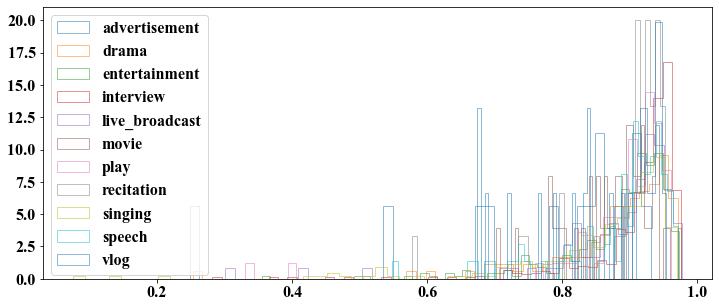

In [50]:
fontsize=16
plt.figure(figsize=(12,5))
for i,dom in enumerate(domains):
#     ax = plt.subplot(len(dom2cos),1,i+1)
    dom_cos = np.array(dom_center2cos[dom])
#     one_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(one_xvectors)
#     plt.scatter(dom_cos, [dom]*len(dom_cos), linewidths=0.1, alpha=0.2)
    _ = plt.hist(dom_cos, alpha=0.5, bins=50, density=True, histtype='step')

plt.legend(domains, fontsize=fontsize) 

_ = plt.yticks(fontsize=fontsize)
_ = plt.xticks(fontsize=fontsize)

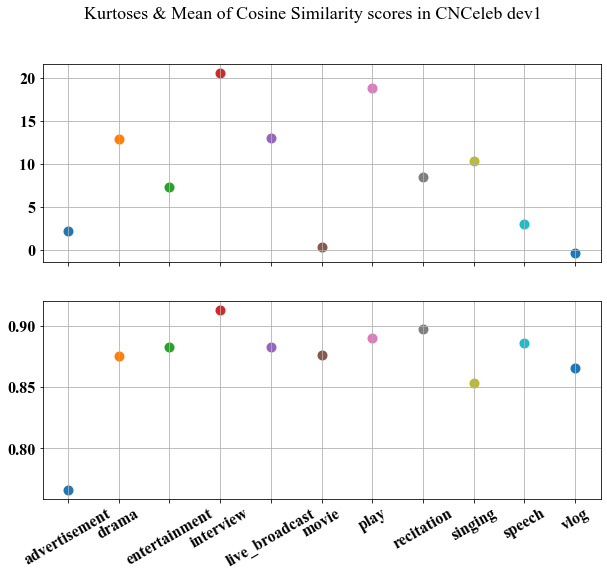

In [98]:
plt.figure(figsize=(10,8))
plt.suptitle("Kurtoses & Mean of Cosine Similarity scores in CNCeleb dev1", fontsize=fontsize+2)
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)

for i,dom in enumerate(domains):
    dom_cos = np.array(dom_center2cos[dom])
    
    mean = dom_cos.mean()
    diffs = dom_cos - mean
    var = np.mean(np.power(diffs, 2.0))
    std = np.power(var, 0.5)
    z_scores = diffs / std

    kurtoses = np.mean(np.power(z_scores, 4.0)) - 3.0
    ax1.scatter([dom], [kurtoses], marker='o', linewidth=4)
    ax2.scatter([dom], [mean], marker='o', linewidth=4)
    
ax1.set_xticklabels([])
for ax in [ax1, ax2]:
    ax.grid()
    
    ax.tick_params(axis='x', labelrotation=30)
    ax.tick_params(axis='both', labelsize=fontsize)
# plt.legend(list(dom2cos.keys()), fontsize=fontsize) 

# Hard ==> Easy

# movie adertisement drama entertainment
# vlog interview singing live_broadcast play 
# speech recitation

In [78]:
spk_center2cos = []

for i, spk in enumerate(spks):
    uids = spk2uid_dict[spk]
    spk_center = []
    for uid in uids:
        spk_center.append(kaldi_io.read_vec_flt(data_dir + '/' +tdnn_xvector_dict[uid]))
    
    this_spk_center = classifier_Center[:, spk2idx[spk]]
    center = np.array(spk_center).mean(axis=0)
    this_cos = torch.nn.functional.cosine_similarity(this_spk_center, torch.tensor(center), dim=0)

    spk_center2cos.append(float(this_cos))
   

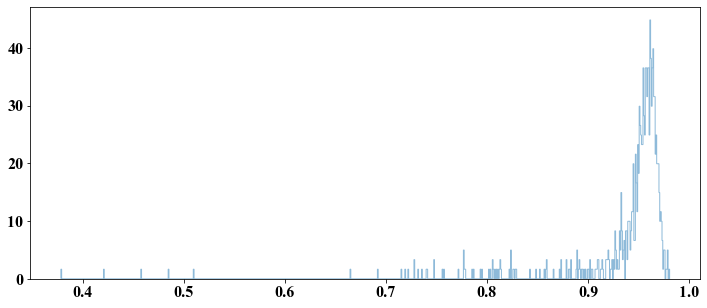

In [79]:
fontsize=16
plt.figure(figsize=(12,5))

center2cos = np.array(spk_center2cos)
#     one_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(one_xvectors)
#     plt.scatter(dom_cos, [dom]*len(dom_cos), linewidths=0.1, alpha=0.2)
plt.hist(center2cos, alpha=0.5, bins=800, density=True, histtype='step')
# plt.legend(domains, fontsize=fontsize) 

_ = plt.yticks(fontsize=fontsize)
_ = plt.xticks(fontsize=fontsize)

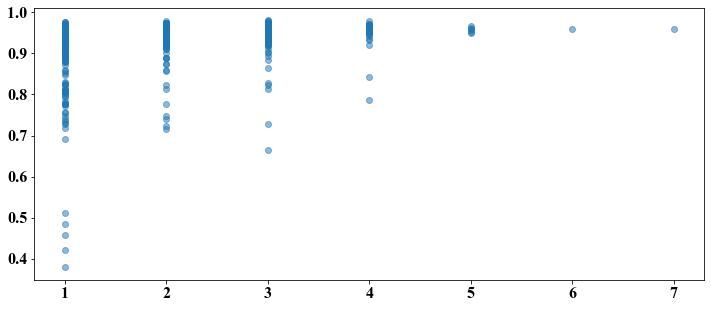

In [83]:
fontsize=16
plt.figure(figsize=(12,5))

center2cos = np.array(spk_center2cos)
#     one_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(one_xvectors)
#     plt.scatter(dom_cos, [dom]*len(dom_cos), linewidths=0.1, alpha=0.2)
# plt.hist(center2cos, alpha=0.5, bins=800, density=True, histtype='step')

plt.scatter(numofdomains, center2cos, alpha=0.5)
# plt.legend(domains, fontsize=fontsize) 

_ = plt.yticks(fontsize=fontsize)
_ = plt.xticks(fontsize=fontsize)

1 :  230
2 :  300
3 :  204
4 :  58
5 :  6
6 :  1
7 :  1


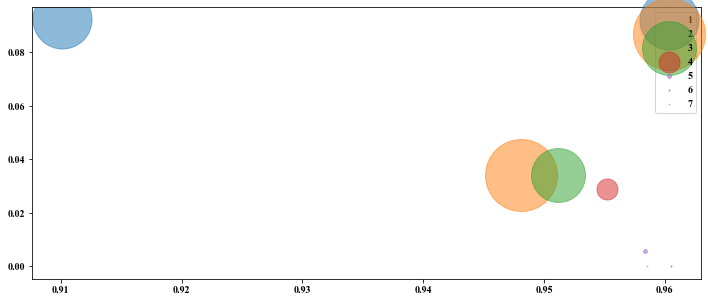

In [97]:
numofdomian2cos = {}
plt.figure(figsize=(12,5))

for n,c in zip(numofdomains, center2cos):
    numofdomian2cos.setdefault(n, []).append(c)

for i in range(1,8):
    mean = np.mean(numofdomian2cos[i])
    std = np.std(numofdomian2cos[i])
    print(i,': ', len(numofdomian2cos[i]))
    plt.scatter(mean, std, len(numofdomian2cos[i])**1.5, alpha=0.5)
    
plt.legend([str(i) for i in range(1,8)])